# 1. Data Preparation

In [1]:
import numpy as np

N = 100
true_b = 1
true_w = 2

np.random.seed(42)
x = np.random.rand(N, 1)
noise = 0.1 * np.random.randn(N, 1)
t = true_b + true_w * x + noise

In [2]:
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch

torch.manual_seed(13)

x_tensor = torch.as_tensor(x).float()
t_tensor = torch.as_tensor(t).float()
dataset = TensorDataset(x_tensor, t_tensor)

ratio = 0.8
n_train = int(N * ratio)
n_val = N - n_train
train_dataset, val_dataset = random_split(dataset, [n_train, n_val])
print(len(train_dataset), len(val_dataset))

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

80 20


# 2. Model Configuration

In [3]:
from torch import nn, optim

device = "cuda" if torch.cuda.is_available() else "cpu"

model = nn.Sequential()
model.add_module("linear", nn.Linear(1, 1))
model.to(device)

loss_fn = nn.MSELoss(reduction="mean")

lr = 0.1
optimizer = optim.SGD(params=model.parameters(), lr=lr)

# 3. Model Training

In [4]:
import datetime
from torch.utils.tensorboard import SummaryWriter

seed = 42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False    
torch.manual_seed(seed)
np.random.seed(seed)

n_epochs = 200
train_losses = []
val_losses = []
suffix = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
log_dir = f"runs/simple_linear_regression.{suffix}"
writer = SummaryWriter(log_dir)
for epoch in range(n_epochs):
    model.train()
    train_loss_batch = []
    for x_batch, t_batch in train_dataloader:
        x_batch = x_batch.to(device)
        t_batch = t_batch.to(device)
        y_batch = model(x_batch)
        loss = loss_fn(y_batch, t_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss_batch.append(loss.item())
    train_loss_mean = np.mean(train_loss_batch)
    train_losses.append(train_loss_mean)
    
    model.eval()
    val_loss_batch = []
    for x_batch, t_batch in val_dataloader:
        x_batch = x_batch.to(device)
        t_batch = t_batch.to(device)
        with torch.no_grad():
            y_batch = model(x_batch)
            val_loss = loss_fn(y_batch, t_batch)
        val_loss_batch.append(val_loss.item())
    val_loss_mean = np.mean(val_loss_batch)
    val_losses.append(val_loss_mean)

    loss_scalars = {
        "training": train_loss_mean,
        "validation": val_loss_mean,
    }
    writer.add_scalars(
        main_tag="Loss",
        tag_scalar_dict=loss_scalars,
        global_step=epoch
    )

In [5]:
print(model.state_dict())

OrderedDict({'linear.weight': tensor([[1.9416]]), 'linear.bias': tensor([1.0235])})


# 4. Loss Curve

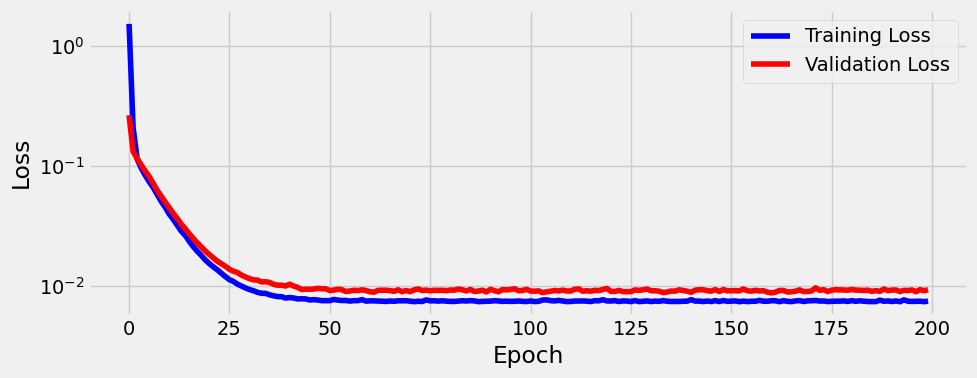

In [6]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(10, 4))
plt.plot(train_losses, label="Training Loss", c="b")
plt.plot(val_losses, label="Validation Loss", c="r")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.tight_layout()

In [7]:
!mkdir runs && ls | grep runs

mkdir: runs: File exists


In [8]:
%load_ext tensorboard


In [9]:
%tensorboard --logdir runs/simple_linear_regression.2025-09-14_23:08:40